In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json


In [4]:
! kaggle competitions download -c fake-news

 76% 28.0M/37.0M [00:00<00:00, 75.5MB/s]
100% 37.0M/37.0M [00:00<00:00, 124MB/s] 
  0% 0.00/9.42M [00:00<?, ?B/s]
100% 9.42M/9.42M [00:00<00:00, 86.7MB/s]
  0% 0.00/40.6k [00:00<?, ?B/s]
100% 40.6k/40.6k [00:00<00:00, 43.8MB/s]


In [5]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [6]:
 ! unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [7]:
#dependencies
import warnings
warnings.filterwarnings("ignore")
!pip install contractions
!pip install kaggle_datasets
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

import re
import pickle
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import gensim
from sklearn.metrics import confusion_matrix
import tensorflow  as tf 
from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
#from kaggle_datasets import KaggleDatasets
#import transformers
#from transformers import TFAutoModel, AutoTokenizer
#from tqdm.notebook import tqdm
#from tokenizers import Tokenizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras

     |████████████████████████████████| 284 kB 5.4 MB/s 
     |████████████████████████████████| 321 kB 42.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85446 sha256=9ae32c4ab5db9e02e77fb948330ad2e45118793af33f71f62aa1f241a6ca2b2d
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
ERROR: Could not find a version that satisfies the requirement kaggle_datasets (from versions: none)
ERROR: No matching distribution found for kaggle_datasets
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpo

In [8]:
df_2 = pd.read_csv("/content/train.csv", header=0, index_col=0)
df_t = pd.read_csv("/content/test.csv", header=0, index_col=0)
df_2 = df_2.drop(['title','author'], axis = 1)
df_t = df_t.drop(['title','author'], axis = 1)
df_2.dropna(inplace = True)
df_t.fillna('',inplace = True)
#print(df_2.isnull().sum(axis = 0))



In [9]:
def clean_text(text_col ):
    text_col = text_col.apply(lambda x: [contractions.fix(word, slang=False).lower() for word in x.split()])
    text_col = text_col.apply(lambda x: [re.sub(r'[^\w\s]','', word)  for word in x])
    stop_words = set(stopwords.words('english'))
    text_col = text_col.apply(lambda x: [word for word in x if word not in stop_words])
    text_col = text_col.apply(lambda x: [word for word in x if re.search("[@_!#$%^&*()<>?/|}{~:0-9]", word) == None])
    return text_col
df_2["text"] = clean_text(df_2["text"])
df_t["text"] = clean_text(df_t["text"])
df_2['label'] = df_2['label'].apply(lambda x: int(x))
y = df_2['label']

In [26]:
y = df_2["label"]
type(y)

pandas.core.series.Series

In [12]:
#lemmatizing
wordnet_lemmatizer = WordNetLemmatizer()
x = []
x_test = []
english_words = set(nltk.corpus.words.words())
for words in df_2['text']:
        tmp = []
        fil_wor = [wordnet_lemmatizer.lemmatize(word, 'n') for word in words if word in english_words]
        tmp.extend(fil_wor)
        x.append(tmp)
        
for words in df_t['text']:
        tmp = []
        fil_wor = [wordnet_lemmatizer.lemmatize(word, 'n') for word in words if word in english_words]
        tmp.extend(fil_wor)
        x_test.append(tmp)
        
df_2["text"] = x
df_t["text"] = x_test


In [19]:
#creating word embedding
x_all = x.copy()
for z in  range(len(x_test)):
    x_all.append(x_test[z])
#n of vectors we are generating
EMBEDDING_DIM = 100
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=x_all,size = EMBEDDING_DIM, window=5, min_count=1)
#print(len(w2v_model.wv.vocab))

#testing a word embedding
print(w2v_model.wv["liberty"])

#similarity between words
word = 'people'
w2v_model.wv.most_similar(word)

[-1.0210294   0.7340223  -1.3515397   1.2159343  -2.2155366   0.98386794
 -2.1478333  -1.0651315   1.3340352  -0.76118726 -0.19682747 -0.49648327
  0.24466458 -0.22960852  1.1910176  -0.29518983 -0.75640893  1.0930058
 -0.9135735   0.9034568  -0.74702567 -1.3447056  -0.296908   -1.9846973
  1.0917635   1.0257062   0.26236418 -1.7354338   0.7083265  -0.4829227
 -1.3476304   0.04792267  1.4100169  -1.3920387   2.2693918  -0.5845117
  0.84619063 -0.3403278   0.04559521  0.4004519  -0.9593401  -1.3295531
 -0.3842638  -0.23930159  0.01646848 -2.1531081   0.00339501 -0.45802894
  0.95812047  0.548929   -0.38548955  1.0736966  -0.8208613  -0.51686925
 -1.1982942  -1.0538876   0.5093148  -1.2459188  -0.10957494  0.60706055
 -1.0909762  -1.0126141   1.1085215  -0.74704635 -1.2361974  -0.977472
  0.5516059   0.52579004 -0.73004854  0.98155963 -1.0357928  -1.559598
  0.18998474 -0.46584985 -2.8941953   1.6652561   0.23881184 -0.55997473
  0.7288743  -0.5143686  -0.5086503  -0.24716623  0.8826993 

[('many', 0.5792583227157593),
 ('believe', 0.5112147331237793),
 ('person', 0.5102234482765198),
 ('everyone', 0.5060974955558777),
 ('honestly', 0.503677487373352),
 ('men', 0.4951854944229126),
 ('know', 0.4866536855697632),
 ('say', 0.4855126142501831),
 ('really', 0.47459936141967773),
 ('sadly', 0.47364482283592224)]

In [20]:
#tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

x = tokenizer.texts_to_sequences(x)
x_test = tokenizer.texts_to_sequences(x_test)
print(x[0][:10])

word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

[33, 1488, 14, 46, 496, 2055, 6721, 8233, 701, 2887]
said -> 1
trump -> 2
one -> 3
would -> 4
people -> 5
u -> 6
time -> 7
new -> 8
like -> 9
also -> 10


In [21]:
#padding
maxlen = 700
x = pad_sequences(x, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [22]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix, vocab_size

#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors, vocab_size = get_weight_matrix(w2v_model.wv, word_index)

In [23]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(Dropout(0.2))
#model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=128,dropout=0.2, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(units=128,dropout=0.2))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          3421500   
                                                                 
 dropout (Dropout)           (None, 700, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 700, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 350, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 350, 128)          98816     
                                                                 
 batch_normalization (BatchN  (None, 350, 128)         512       
 ormalization)                                          

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y)
model.fit(X_train, y_train, validation_data= (X_test,y_test), epochs=50)

Epoch 1/50
487/487 [==============================] - 85s 145ms/step - loss: 0.3440 - acc: 0.8537 - val_loss: 0.2814 - val_acc: 0.8867
Epoch 2/50
487/487 [==============================] - 69s 143ms/step - loss: 0.2385 - acc: 0.9016 - val_loss: 0.1876 - val_acc: 0.9247
Epoch 3/50
487/487 [==============================] - 68s 140ms/step - loss: 0.2010 - acc: 0.9207 - val_loss: 0.3125 - val_acc: 0.8835
Epoch 4/50
487/487 [==============================] - 69s 141ms/step - loss: 0.1812 - acc: 0.9277 - val_loss: 0.1578 - val_acc: 0.9422
Epoch 5/50
487/487 [==============================] - 69s 142ms/step - loss: 0.1774 - acc: 0.9305 - val_loss: 0.3380 - val_acc: 0.8835
Epoch 6/50
487/487 [==============================] - 69s 142ms/step - loss: 0.1648 - acc: 0.9355 - val_loss: 0.1584 - val_acc: 0.9362
Epoch 7/50
487/487 [==============================] - 69s 142ms/step - loss: 0.1468 - acc: 0.9421 - val_loss: 0.1554 - val_acc: 0.9347
Epoch 8/50
487/487 [==============================] - 6

0.9449046426507417
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2561
           1       0.93      0.96      0.95      2630

    accuracy                           0.94      5191
   macro avg       0.95      0.94      0.94      5191
weighted avg       0.95      0.94      0.94      5191



Text(69.0, 0.5, 'Truth')

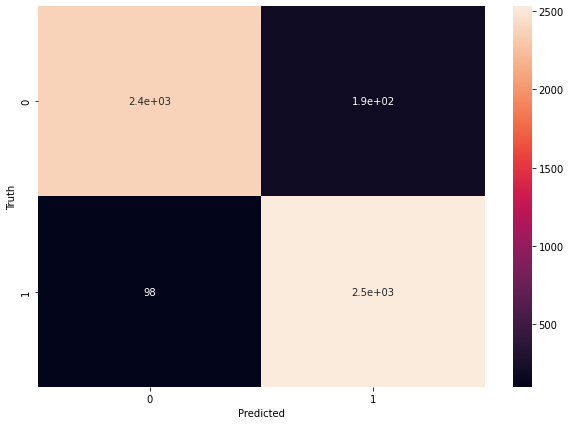

In [28]:
#validation_data_performance evaluation
y_pred = (model.predict(X_test) >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
#test_data_for_scoring_on_kaggle
y_t = (model.predict(x_test) >= 0.5).astype("int")
result = pd.DataFrame({"id" :df_t.index, "label":y_t.squeeze() }, index = None )
result.to_csv("result_rnn.csv",index = False)

In [30]:
#let's include an attention layer in our model
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features)+ self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score),axis = 1)
        context_vector = attention_weights * features
        context_vector  = tf.reduce_sum(context_vector, axis = 1)
        return context_vector, attention_weights

In [ ]:
'''#dd attention layer to the deep learning network
class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', #shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', #shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(Attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context'''

In [34]:
#RNN with Attention model
sequence_input = Input(shape = (maxlen,), dtype = "int32")
embedding = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False)(sequence_input)
dropout = Dropout(0.2)(embedding)

conv1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(dropout)
maxp = MaxPooling1D(pool_size=2)(conv1)
#(lstm, state_h, state_c) = LSTM(units=128,return_sequences=True,dropout=0.2, return_state= True)(maxp)
#bn1 = BatchNormalization()((lstm, state_h, state_c))
(lstm, state_h, state_c) = LSTM(units=128,dropout=0.2, return_sequences=True, return_state= True)(maxp)
context_vector, attention_weights = Attention(10)(lstm, state_h)
densee = Dense(20, activation='relu')(context_vector)
#bn = BatchNormalization()(densee)
dropout2 = Dropout(0.2)(densee)
densef = Dense(1, activation='sigmoid')(dropout2)
model = tensorflow.keras.Model(inputs = sequence_input, outputs = densef)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
display(model.summary())
history = model.fit(X_train, y_train, validation_data= (X_test,y_test), epochs=50)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 700)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 700, 100)     3421500     ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 700, 100)     0           ['embedding_2[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)              (None, 700, 64)      19264       ['dropout_3[0][0]']              
                                                                                            

None

Epoch 1/50
487/487 [==============================] - 40s 76ms/step - loss: 0.3565 - acc: 0.8475 - val_loss: 0.2530 - val_acc: 0.8969
Epoch 2/50
487/487 [==============================] - 36s 75ms/step - loss: 0.2336 - acc: 0.9100 - val_loss: 0.1945 - val_acc: 0.9210
Epoch 3/50
487/487 [==============================] - 36s 75ms/step - loss: 0.2049 - acc: 0.9227 - val_loss: 0.1795 - val_acc: 0.9293
Epoch 4/50
487/487 [==============================] - 37s 75ms/step - loss: 0.1721 - acc: 0.9331 - val_loss: 0.1644 - val_acc: 0.9370
Epoch 5/50
487/487 [==============================] - 37s 75ms/step - loss: 0.1588 - acc: 0.9404 - val_loss: 0.1769 - val_acc: 0.9312
Epoch 6/50
487/487 [==============================] - 37s 75ms/step - loss: 0.1501 - acc: 0.9432 - val_loss: 0.2050 - val_acc: 0.9216
Epoch 7/50
487/487 [==============================] - 37s 75ms/step - loss: 0.1385 - acc: 0.9473 - val_loss: 0.1497 - val_acc: 0.9422
Epoch 8/50
487/487 [==============================] - 37s 75ms

0.94548256597958
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2561
           1       0.93      0.97      0.95      2630

    accuracy                           0.95      5191
   macro avg       0.95      0.95      0.95      5191
weighted avg       0.95      0.95      0.95      5191



Text(69.0, 0.5, 'Truth')

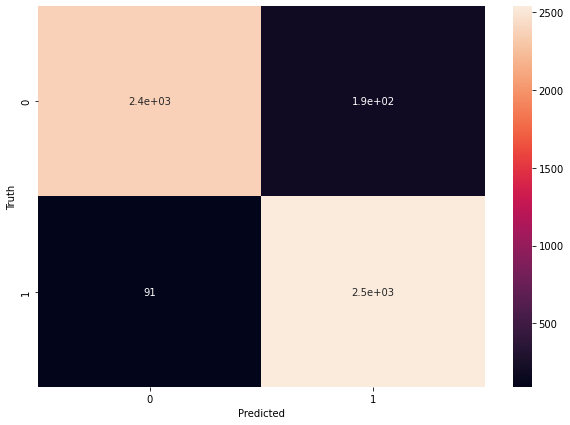

In [35]:
#checking accuracy on validation data
y_pred = (model.predict(X_test) >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

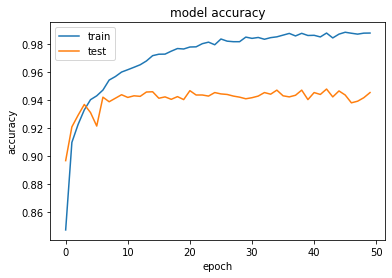

In [39]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

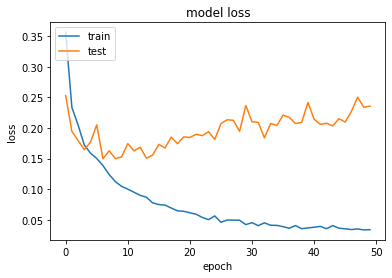

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
y_t = (model.predict(x_test) >= 0.5).astype("int")
result = pd.DataFrame({"id" :df_t.index, "label":y_t.squeeze() }, index = None )
result.to_csv("result_rnnattenion.csv",index = False)